# CIS 1902 Homework 4 Part 2: Web Scraping 👕 👠 👗 👟 🧥

**Due Friday March 31, 2023 11:59 pm EST**

## Objectives

- Practice navigating web page sources and scraping
- Familiarization with image manipulation


**First, make a copy of this Colab to your Google Drive by clicking "Copy to Drive" in the upper left or `File -> save a copy in Drive` so you can save any changes you make.**

- **Name:** TODO
- **PennKey:** TODO
- **Number of hours spent on homework:** 
    - **Part 2**: TODO

Collaboration is NOT permitted.

In the functions below the "NotImplementedError" exception is raised, for
you to fill in. The interpreter will not consider the empty code blocks
as syntax errors, but the "NotImplementedError" will be raised if you
call the function. You will replace these raised exceptions with your
code completing the function as described in the docstrings.

Now that we've trained a deep learning model that can classify images of clothing in Part 1, let's test out its performance on some real-world data scraped from the web. 

First, let's re-load our saved model from part 1 of the homework. Upload your `model.pkl` file into this runtime and run the cell below:

In [ ]:
import torch
from torchvision import transforms

if __name__ == '__main__':
    model = torch.load("model.pkl", map_location="cpu")

## Installation and setup

Run the below cells to import and install the necessary modules for the assignment:

In [ ]:
!pip install requests-html
!pip install nest-asyncio
!pip install beautifulsoup4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Web scraping
import asyncio
import nest_asyncio
import torch

from requests_html import HTMLSession, AsyncHTMLSession
from bs4 import BeautifulSoup

# nested asyncio is needed for running async functions within a Jupyter notebook
nest_asyncio.apply()

# Image processing
import cv2
import matplotlib.pyplot as plt
import numpy as np

from google.colab.patches import cv2_imshow
from skimage import io

## Obtaining real-world images [1 pt]

Let's look for images of clothing online, ideally cropped to a square so that we can easily feed the images into our deep learning model. The Uniqlo Men's and Women's subsites have good examples of this under "Search by Category":

- https://www.uniqlo.com/us/en/men
- https://www.uniqlo.com/us/en/women

> The CIS 1920 teaching staff does not endorse or sponsor any commercial product, service or activity. References to any products, services, hyperlink text to third parties or other information does not constitute or imply its endorsement, sponsorship, or recomendation by the CIS 1920 staff or the University of Pennsylvania.



<img src="https://www.seas.upenn.edu/~cis1920/tliu/s23/hws/hw5/hw5_fashion_website_men.png"  width="600px">

<img src="https://www.seas.upenn.edu/~cis1920/tliu/s23/hws/hw5/hw5_fashion_website_women.png"  width="600px">


We *could* navigate to these sites and download the images manually, but this quickly becomes tedious for even the 12 images shown above. Instead, we'll use the browser automation and beautifulsoup library that we saw in lecture to programmatically extract the images for us.

We've provided the following `get_html_response()` function below which returns a `requests_html.HTMLResponse` object for the given URL that we can then traverse.

In [ ]:
def get_html_response(url, email, timeout=15):
    """Wraps asynchronous requests_html calls to render javascript.
    
    We won't cover coroutines in this course, but if you're interested in
    learning more the official docs give a good intro: 
    https://docs.python.org/3/library/asyncio-task.html#

    Args:
        url (str): the url webpage to render.
        email (str): email address to attach to request header.
        timeout (int): seconds to wait for website response, default 10.

    Returns:
        HTMLResponse: the requests_html HTMLResponse object after loading the 
            webpage.
    
    """

    headers = {
        "user-agent": f"CIS 1920 Spring 2023 HW3 by {email}"
    }
    sleep = 5
    async def async_requests(url):
        r = await AsyncHTMLSession().get(url, headers=headers)
        # sleep to allow for all javascript to render
        await r.html.arender(timeout=timeout, sleep=sleep)
        return r
    print(f"Rendering webpage, including Javascript (may take up to {timeout+sleep} seconds)...")        
    return asyncio.run(async_requests(url))

Note that the first call to `get_html_response()` will trigger a download of the headless Chromium web browser, so you may need to call the function again or adjust the `timeout` time.

In [ ]:
if __name__ == '__main__':
    # Pick one site to extract images from.
    url = "https://www.uniqlo.com/us/en/women"
    #url = "https://www.uniqlo.com/us/en/men"
    
    # TODO fill out your email to populate the request headers
    email = "liutony@seas.upenn.edu"

    # the first run will download chromium driver       
    # if you receive a timeout error, try increasing the timeout parameter
    response = get_html_response(url, email, timeout=10)

Rendering webpage, including Javascript (may take up to 15 seconds)...


Your job is to examine the source of either of the websites provided above and
write beautifulsoup parsing to extract the twelve square image urls.

**Hint:** the `fr-ec-cms-category-image-container` **div** class is the one we want to be looking for to extract the square "Shop by category" images.

In [ ]:
def extract_img_urls(response):
    """
    Extracts the relevant image URLs from the provided HTMLResponse.

    This function's behavior will be "hardcoded" to the specific fashion website
    webpages. We expect this function to only extract the 12 square image urls
    as shown above on either the men's or women's site.

    Args:
        response (HTMLResponse)

    Returns:
        list: list of extracted image urls, 12 in total
    """
    soup = BeautifulSoup(response.html.raw_html, "html.parser")

    # Begin TODO
    img_urls = []
    for div in soup.find_all("div", class_="fr-ec-cms-category-image-container"):
        for img in div.find_all("img"):
            url = img['src']
            if not url.startswith("https:"):
                url = "https:" + url 
            img_urls.append(url)
    # End TODO

    return img_urls

Use the cell below to test your implementation:




In [ ]:
if __name__ == "__main__":
    img_urls = extract_img_urls(response)
    print(img_urls[0])

https://im.uniqlo.com/global-cms/spa/resa21a851aec87c0097d7fb96b52a600ccfr.jpg


## Basic image processing [0.5 pt]

Now that we have image URLs, we'll need to process the image so that it can be fed into our Fashion MNIST model. At a minimum, this requires:

- convert images to grayscale
- shrinking the width and height to 28 by 28 pixels

Implement `process_img_fmnist()`  below to perform these 
transformations by using the cv2 functions `cv2.cvtColor()` and `cv2.resize()` we discussed in lecture.

In [ ]:
def process_img_fmnist(url):
    """
    Transforms the specified url into a NumPy array that can be read into a 
    PyTorch model trained to classify fashion MNIST images.
    
    The resulting image must be of shape (28, 28).
    
    Args:
        url (str): valid URL to a .jpg or .png image.

    Returns:
        np.ndarray: a NumPy array of shape (28, 28)
    """
    #raise NotImplementedError

    # reads the image at the given url
    orig_img = io.imread(url)
    gray_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
    small_img = cv2.resize(gray_img, (28, 28), interpolation=cv2.INTER_AREA)

    return small_img

Use the cell below to test your implementation:


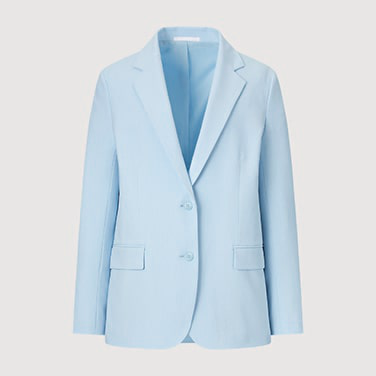

In [ ]:
if __name__ == '__main__':
    orig_img = io.imread(img_urls[0])
    cv2_imshow(orig_img)

    converted_img = process_img_fmnist(img_urls[0])
    cv2_imshow(converted_img)

## Visualizing model predictions




Now, let's see how well our model does classifying previously unseen images from a different fashion retailer. We've provided the `display_model_preds()` below that will take your implemented functions from above and generate a 
plot displaying your model's predictions.

In [ ]:
img_label_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

def display_model_preds(img_urls, img_proc_func, model, img_name):
    """
    Displays model's predictions on the given images. 
    
    Requires process_img_fmnist() to be implemented.

    Args:
        img_urls (list): a list of image URLs to feed into model.
        img_proc_func (function): an image processing function 
        model (torch.nn.Sequential): a nn.Sequential model trained on fmnist.
        img_name (str): the name of the generated jpg image

    Returns:
        None, but displays an image with model predictions for the given images
            and saves the image to {img_name}.jpg
    """

    imgs_to_classify = np.zeros((len(img_urls), 28, 28))

    for i, url in enumerate(img_urls):
        img = img_proc_func(url)
        imgs_to_classify[i] = img

    imgs_to_classify = np.expand_dims(imgs_to_classify, axis=1)

    # apply the same Normalization as 
    imgs_tensor = transforms.Normalize(mean=0.5, std=0.5).forward(torch.from_numpy(imgs_to_classify).float())

    output = model(imgs_tensor)
    predicted = torch.argmax(output, dim=1)
    
    predicted = predicted.numpy()

    # Note that we've hardcoded the shape to take in 12 images
    fig, axes = plt.subplots(3,4, figsize=(10,7))
    axes = axes.ravel()

    for i, pred in enumerate(predicted):
        ax = axes[i]
        ax.imshow(imgs_to_classify[i].reshape(28,28), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("Prediction {}: {}".format(i, img_label_dict[pred]))

    fig.suptitle(f"Predictions using {img_proc_func.__name__}()")

    fig.savefig(f"{img_name}.png")

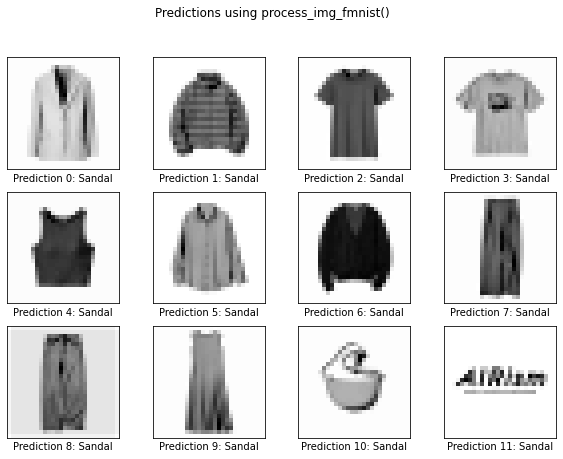

In [ ]:
if __name__ == '__main__':
    display_model_preds(img_urls, process_img_fmnist, model, "baseline_img_preprocess")

 ## Custom image pre-processing [0.5 pt]

The predictions made above may be surprisingly poor! We'll need apply additional transformations to produce more reasonable output. Using the `process_img_fmnist()` implementation above as a starting point, apply your own image pre-processing in the `custom_process_img()` function below.

There are no right or wrong preprocessing steps to take, but some transformations to explore are:

- cropping the image before resizing by using slice notation: `img[y:y+height, x:x+width]`
- inverting the image by using `cv2.bitwise_not()`
- thresholding portions of the image to black by using logical indexing: `img[img <= THRESHOLD] = 0`
- any others, feel free to explore the [OpenCV image processing documentation](https://docs.opencv.org/4.7.0/d2/d96/tutorial_py_table_of_contents_imgproc.html)!

In [ ]:
def custom_process_img(url):
    """
    Transforms the specified url into a NumPy array that can be read into a 
    PyTorch model trained to classify fashion MNIST images. Performs additional
    image pre-processing to improve model performance.
    
    The resulting image must be of shape (28, 28).
    
    Args:
        url (str): valid URL to a .jpg or .png image.

    Returns:
        np.ndarray: a NumPy array of shape (28, 28)
    """
    #raise NotImplementedError

    # reads the image at the given url
    orig_img = io.imread(url)
    gray_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
    inv_img = cv2.bitwise_not(gray_img)
    inv_img[inv_img <= 20] = 0
    _, background = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    #cv2_imshow(background)
    no_bg_img = cv2.bitwise_and(gray_img, background)
    alpha = 1 # Contrast control
    beta = 10 # Brightness control
    #no_bg_img = cv2.convertScaleAbs(no_bg_img, alpha=alpha, beta=beta)
    small_img = cv2.resize(inv_img, (28, 28), interpolation=cv2.INTER_AREA)

    #torch_img = torch.from_numpy()

    return small_img

Run the cell below to compare your image processing to the baseline image processing. As part of your submission to Gradescope, upload the `custom_img_preprocess.png` image file generated.

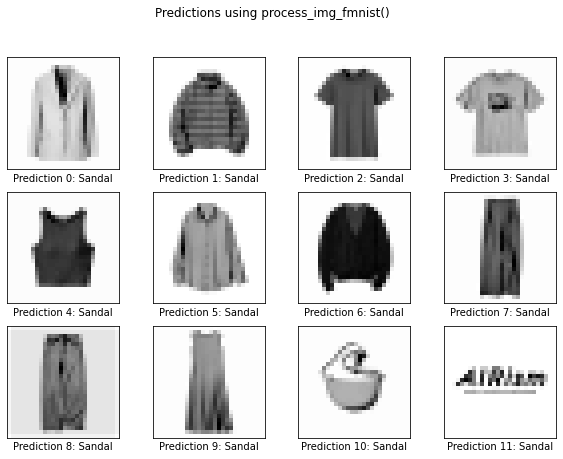

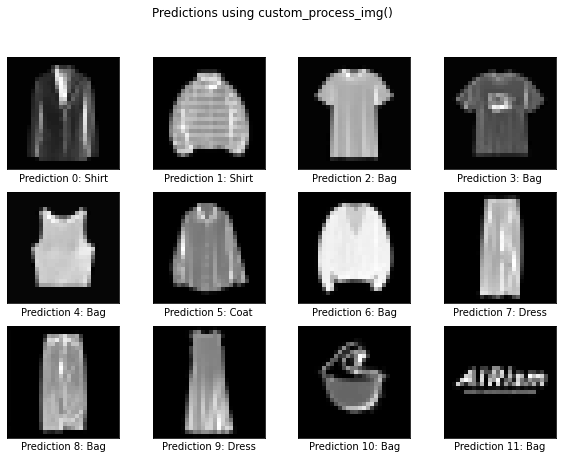

In [ ]:
if __name__ == '__main__':
    display_model_preds(img_urls, process_img_fmnist, model, "baseline_img_preprocess")

    display_model_preds(img_urls, custom_process_img, model, "custom_img_preprocess")

## Discussion questions [1 pt]

1. Describe the image pre-processing methods you tried. Which transformations made the biggest difference in changing the model output?

2. Which image predictions [0 - 11] made by your model (if any) do you think are sensible? Do you think the model does a good job "generalizing" to these fashion images?

> **Note**: since your `custom_process_img()` implementation is open-ended, these discussion questions do not have "correct/incorrect" answers.

# Submission

Afer you have completed the worksheet, download the Colab notebook as a `hw5_web.py` file by going to `File -> Download .py`. Then submit your `hw5_web.py` and `custom_img_preprocess.png` files alongside the files from Part 1 to Gradescope.

**Note: since you will be submitting Colab-formatted .py files, we will not be grading code style for this assignment.**

# Rubric

| Sections | Points |
|---------|--------|
 **Part 2** |
`extract_img_url()` | 1
`process_img_fmnist()` | 0.5
`custom_img_preprocess.png` uploaded | 0.5
Part 2 discussion | 1

---

| All Sections | Points |
|---------|--------|
All functions implemented | 0.5
Pennkey, name, and hours estimate | 0.5
Part 1 | 6
Part 2 | 3
 **Total** | 10

## Extra credit

| Section | Points |
|---------|--------|
achieve >89% test accuracy | 1

# Code sandbox

In [ ]:
import pickle

pickle.dump(response, open("html_response.pkl", "wb"))

In [ ]:
orig_img.shape

(750, 750, 3)

In [ ]:
type(orig_img)


numpy.ndarray

In [ ]:
url

'https://www.uniqlo.com/us/en/women'

In [ ]:
type(type(crop_img))

import unittest

unittest.TestCase().assertIsInstance("test", np.ndarray, msg="you dun goofed")

AssertionError: ignored

In [ ]:
img_urls[0]

'https://im.uniqlo.com/global-cms/spa/resa21a851aec87c0097d7fb96b52a600ccfr.jpg'

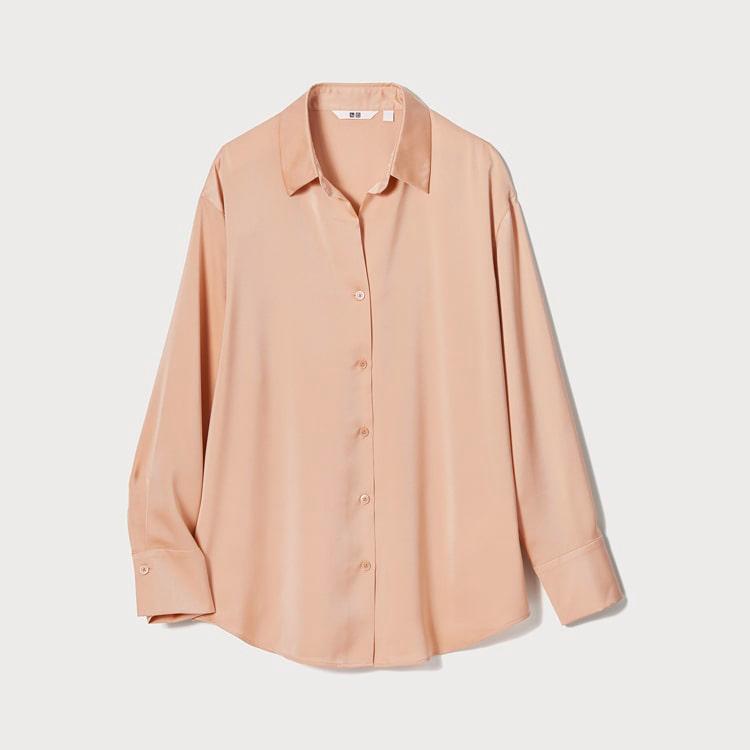

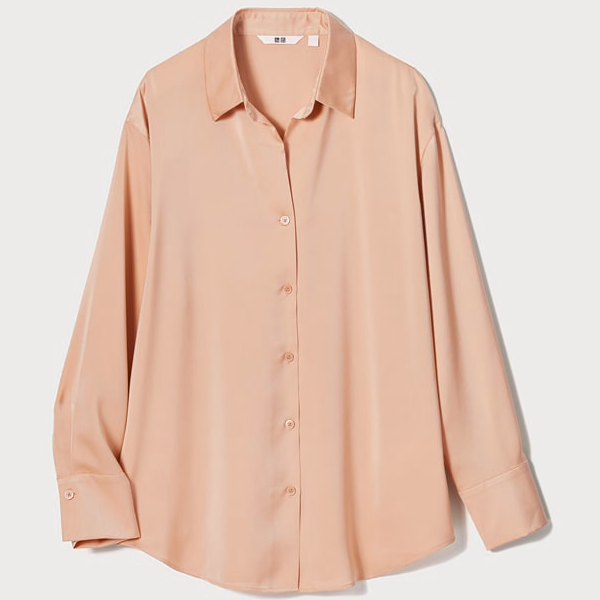

In [ ]:
x = 75
y = 75
width = 600
height = 600
crop_img = orig_img[y:y+height, x:x+width].copy()
cv2_imshow(orig_img)
cv2_imshow(crop_img)

### Convert to grayscale

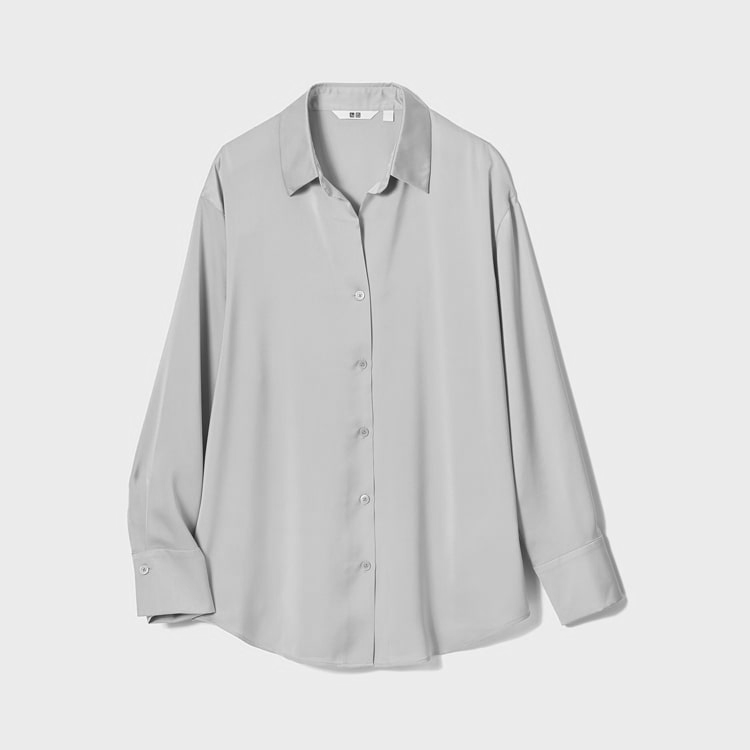

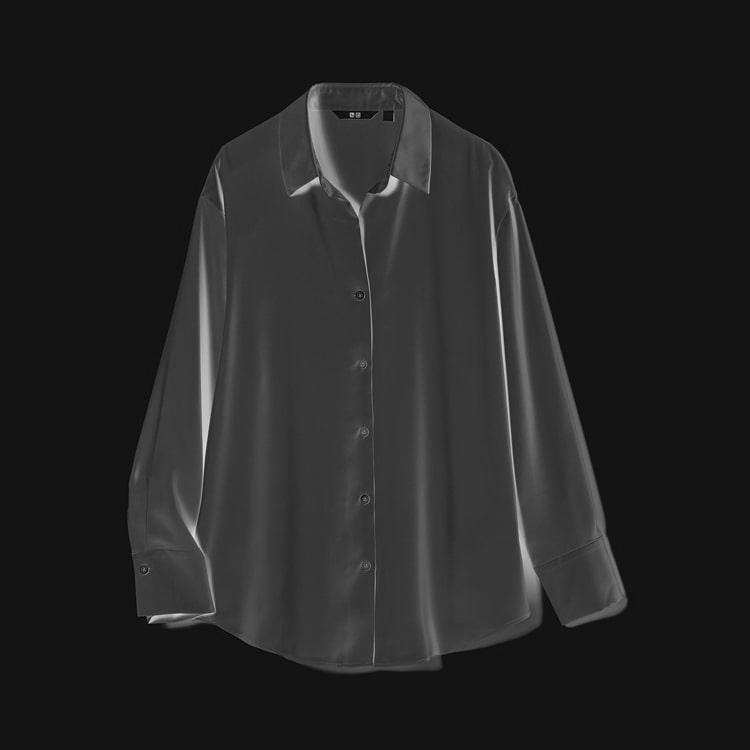

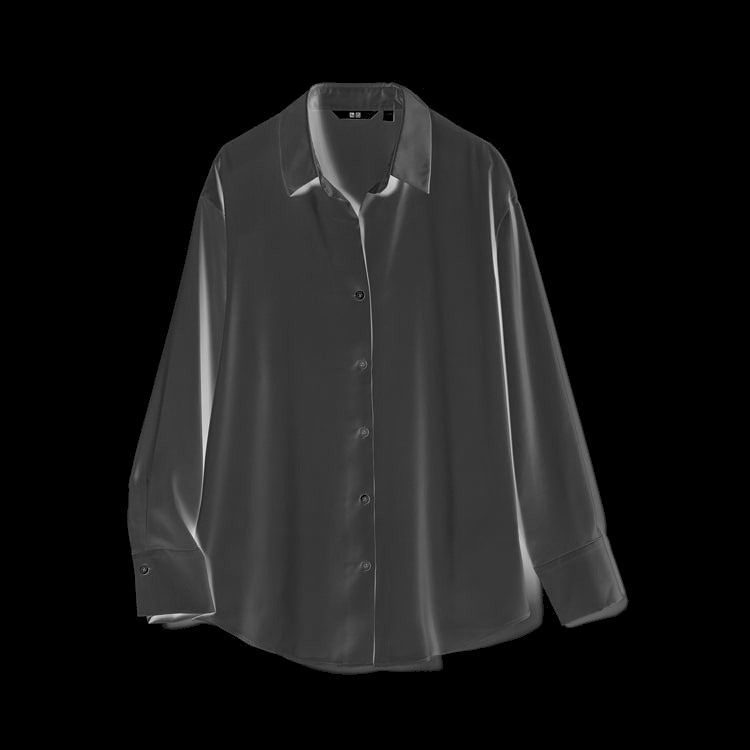

In [ ]:
gray_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)

cv2_imshow(gray_img)
#cv2_imshow(mod_img)
inv_img = cv2.bitwise_not(gray_img)
_, background = cv2.threshold(gray_img, 243, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
cv2_imshow(inv_img)
mod_img = inv_img.copy()
mod_img[mod_img <= 25] = 0
_, background = cv2.threshold(inv_img, 0, 25, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
cv2_imshow(mod_img)

### Make background image black

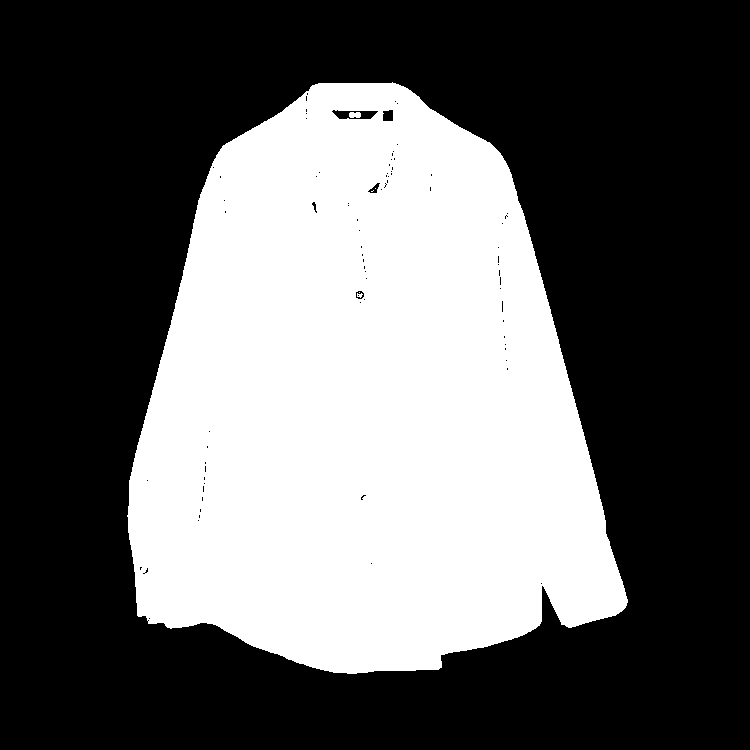

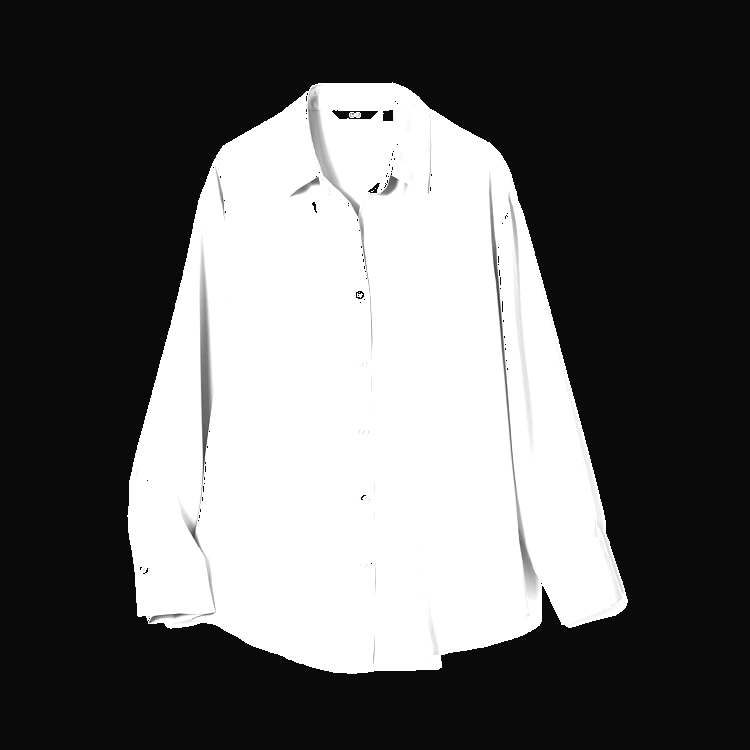

In [ ]:
_, background = cv2.threshold(gray_img, 243, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
cv2_imshow(background)
no_bg_img = cv2.bitwise_and(gray_img, background)
alpha = 1.5 # Contrast control
beta = 10 # Brightness control
no_bg_img = cv2.convertScaleAbs(no_bg_img, alpha=alpha, beta=beta)
cv2_imshow(no_bg_img)

### Shrink image to Fashion MNIST dimensions

In [ ]:
small_img = cv2.resize(gray_img, (28, 28))
cv2_imshow(small_img)

In [ ]:
small_img.shape

(28, 28)

In [ ]:
type(small_img)

numpy.ndarray

In [ ]:
len(img_urls)

12

In [ ]:
import numpy as np
uq_examples = np.zeros((len(img_urls), 28, 28))

for i, url in enumerate(img_urls):
    print(url)
    if not url.startswith("https:"):
        url = "https:" + url 
    img = process_img_fmnist(url)
    uq_examples[i] = img

uq_examples = np.expand_dims(uq_examples, axis=1)

In [ ]:
uq_examples = np.expand_dims(uq_examples, axis=1)

In [ ]:
transforms.Normalize(mean=0.5, std=0.5).forward(torch.from_numpy(uq_examples).float()).shape

In [ ]:
_, uq_predicted = torch.max(output, dim=1)

In [ ]:
uq_predicted.shape

In [ ]:
preds = uq_predicted.numpy()

fig, axes = plt.subplots(3,4, figsize=(10,8))
axes = axes.ravel()

for i, pred in enumerate(preds):
    ax = axes[i]
    ax.imshow(uq_examples[i].reshape(28,28), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("Prediction: {}".format(img_dict[pred]))

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=0.5, std=0.5)])

testset = datasets.FashionMNIST('pytorch/', download=True, train=False, 
                                    transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=12, 
                                            shuffle=True)

In [ ]:
images.shape

In [ ]:
images, labels = next(iter(testloader))
outputs = model(images)
_, predicted = torch.max(outputs, 1)
c = (predicted == labels).squeeze()
